In [132]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm

import urllib
from urllib.error import HTTPError
from deap import tools
import data
%matplotlib inline

# Travelling salesman problem

In [2]:
# BERLIN52

n = 52
print('Problem size: %d' % n)

coords = np.array([565.0, 575.0, 25.0, 185.0, 345.0, 750.0, 945.0, 685.0, 845.0, 655.0, 880.0, 660.0, 25.0, 230.0, 525.0, 1000.0, 580.0, 1175.0, 650.0, 1130.0, 1605.0, 620.0, 1220.0, 580.0, 1465.0, 200.0, 1530.0, 5.0, 845.0, 680.0, 725.0, 370.0, 145.0, 665.0, 415.0, 635.0, 510.0, 875.0, 560.0, 365.0, 300.0, 465.0, 520.0, 585.0, 480.0, 415.0, 835.0, 625.0, 975.0, 580.0, 1215.0, 245.0, 1320.0, 315.0, 1250.0, 400.0, 660.0, 180.0, 410.0, 250.0, 420.0, 555.0, 575.0, 665.0, 1150.0, 1160.0, 700.0, 580.0, 685.0, 595.0, 685.0, 610.0, 770.0, 610.0, 795.0, 645.0, 720.0, 635.0, 760.0, 650.0, 475.0, 960.0, 95.0, 260.0, 875.0, 920.0, 700.0, 500.0, 555.0, 815.0, 830.0, 485.0, 1170.0, 65.0, 830.0, 610.0, 605.0, 625.0, 595.0, 360.0, 1340.0, 725.0, 1740.0, 245.0])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
print('Distance matrix shape:\n', A.shape)

p = [0, 48, 31, 44, 18, 40,  7,  8,  9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24,  3,  5, 14,  4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29,  1,  6, 41, 20, 16,  2, 17, 30, 21]
print('Optimal solution:\n', p)

Problem size: 52
Distance matrix shape:
 (52, 52)
Optimal solution:
 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


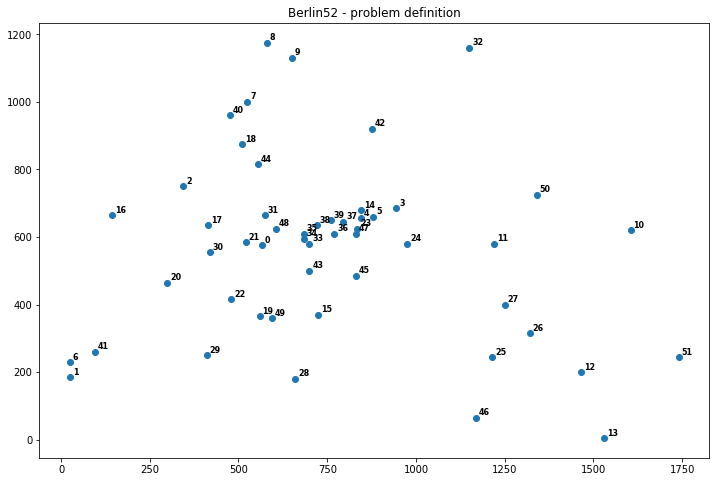

In [3]:
plt.figure(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

plt.title('Berlin52 - problem definition')

plt.show()

In [4]:
def plot_route(route):
    plt.figure(figsize=(12,8))
    fig, ax = plt.subplots(figsize=(12,8))

    plt.plot(coords[:, 0], coords[:, 1], 'o')

    for i in range(n):
        plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

    ax.add_line(Line2D(
        [coords[0, 0], coords[route[0], 0]],
        [coords[0, 1], coords[route[0], 1]],
        linewidth=1, color='gray'))
    plt.text((coords[0, 0] + coords[route[0], 0])/2 + 6,
             (coords[0, 1] + coords[route[0], 1])/2 + 6,
             '%d' % A[0, route[0]], fontdict={'weight':'normal', 'size':7})
    for i in range(1, len(route)):
        ax.add_line(Line2D(
            [coords[route[i-1], 0], coords[route[i], 0]],
            [coords[route[i-1], 1], coords[route[i], 1]],
            linewidth=1, color='gray'))
        plt.text((coords[route[i-1], 0] + coords[route[i], 0])/2 + 6,
                 (coords[route[i-1], 1] + coords[route[i], 1])/2 + 6,
                 '%d' % A[route[i-1], route[i]], fontdict={'weight':'normal', 'size':7})
    ax.add_line(Line2D(
        [coords[route[-1], 0], coords[0, 0]],
        [coords[route[-1], 1], coords[0, 1]],
        linewidth=1, color='gray'))
    plt.text((coords[route[-1], 0] + coords[0, 0])/2 + 6,
             (coords[route[-1], 1] + coords[0, 1])/2 + 6,
             '%d' % A[route[-1], 0], fontdict={'weight':'normal', 'size':7})

    plt.title('Berlin52 - optimal solution')

    plt.show()

<Figure size 864x576 with 0 Axes>

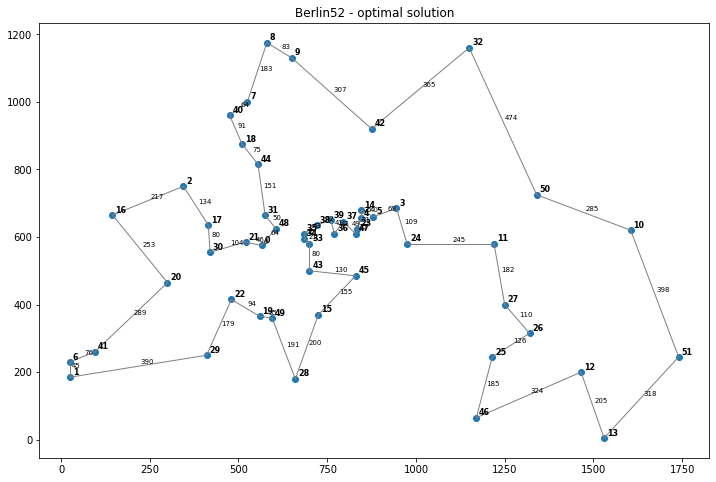

In [5]:
plot_route(p)

# 1. SGA-PMX

**PMX Crossover** <br>
PMX Crossover is a genetic algorithm operator. <br>
For some problems it offers better performance than most other crossover techniques. <br>
Basically, parent 1 donates a swath of genetic material and the corresponding swath  <br>
from the other parent is sprinkled about in the child. <br>
Once that is done, the remaining alleles are copied direct from parent 2. <br>

In [6]:
def tsp_objective_function(p, A):
    s = 0.0
    for i in range(n):
        s += A[p[i-1], p[i]]
    return s

#### How to chose good crossover points?
My ideas: <br>
1. Random 2 points
2. Fix swath size, draw only beginning 
3. Draw 'a' from left half, 'b' from right half

In [7]:
def PMX(ind1, ind2):
    n = len(ind1)
    a, b = np.random.randint(0, n, 2)
    if a > b:
        a, b = b, a
        
#     a = 20
#     b = 30
        
    chld1 = [-1] * n
    chld2 = [-1] * n
    
    chld1[a: b + 1] = ind1[a: b + 1]
    chld2[a: b + 1] = ind2[a: b + 1]
    
    used1 = set(chld1)
    used2 = set(chld2)
    
    lookup1 = [0] * n
    lookup2 = [0] * n
    
    for i in range(n):
        lookup1[ind1[i]] = i
        lookup2[ind2[i]] = i
    
    r = [i for i in range(a + 1)] + [i for i in range(b, n)]
    
    for i in r:
        if chld1[i] == -1:
            if ind2[i] not in used1:
                chld1[i] = ind2[i]
                used1.add(ind2[i])
                
        if chld2[i] == -1:
            if ind1[i] not in used2:
                chld2[i] = ind1[i]
                used2.add(ind1[i])
    
    for i in r:
        if chld1[i] == -1:
            candidate = ind2[i]
            while candidate in used1:
                candidate = ind2[lookup1[candidate]]
            chld1[i] = candidate
            used1.add(candidate)
                
        if chld2[i] == -1:
            candidate = ind1[i]
            while candidate in used2:
                candidate = ind1[lookup2[candidate]]
            chld2[i] = candidate
            used2.add(candidate)

    return chld1, chld2 

In [8]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

In [9]:
def random_swap(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    p[i], p[j] = p[j], p[i]
    return p

In [10]:
print('Optimal cost:', tsp_objective_function(p, A))

Optimal cost: 7544.365901904086


In [167]:
def SGA(population_size=500, 
        chromosome_length=n, 
        crossover_probability=0.95, 
        mutation_probability=0.25,
        number_of_iterations = 201,
        crossover=PMX,
        mutation=reverse_sequence_mutation,
        distance_matrix=A,
        objective_function=tsp_objective_function,
        debug=True):
    
    number_of_offspring = population_size
    time0 = time.time()

    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))
    cost_values = []

    # generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in range(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in range(population_size):
        objective_values[i] = objective_function(current_population[i, :], distance_matrix)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum() 
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = \
                crossover(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :] = current_population[parent_indices[2*i], :].copy()
                children_population[2*i+1, :] = current_population[parent_indices[2*i+1]].copy()

        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = mutation(children_population[i, :])

        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = objective_function(children_population[i, :], distance_matrix)

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]

        # recording some statistics
        if best_objective_value < objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]

        cost_values.append([objective_values.min(), objective_values.mean(), objective_values.max()])
        if t % 10 == 0 and debug:
            print(f'iter: {t},\
     || time: {time.time() - time0:.2f},\
     || min: {objective_values.min():.2f},\
     || mean: {objective_values.mean():.2f},\
     || max: {objective_values.max():.2f},\
     || std: {objective_values.std():.2f}')
            
    return cost_values, current_population

## 1. PMX + Reverse Sequence Mutation

In [91]:
cost_values, current_population = SGA()

iter: 0,     || time: 0.07,     || min: 24824.49,     || mean: 28381.78,     || max: 29674.21,     || std: 985.67
iter: 10,     || time: 0.49,     || min: 19667.31,     || mean: 22058.34,     || max: 22868.43,     || std: 677.85
iter: 20,     || time: 0.94,     || min: 16603.13,     || mean: 18060.90,     || max: 18684.31,     || std: 454.36
iter: 30,     || time: 1.35,     || min: 14581.97,     || mean: 15667.78,     || max: 15965.24,     || std: 247.59
iter: 40,     || time: 1.77,     || min: 13016.70,     || mean: 13424.09,     || max: 13650.42,     || std: 140.87
iter: 50,     || time: 2.19,     || min: 11711.48,     || mean: 12509.31,     || max: 12584.29,     || std: 103.98
iter: 60,     || time: 2.60,     || min: 10628.44,     || mean: 11143.37,     || max: 11266.41,     || std: 116.15
iter: 70,     || time: 3.02,     || min: 9619.29,     || mean: 9983.65,     || max: 10083.41,     || std: 93.83
iter: 80,     || time: 3.44,     || min: 9029.32,     || mean: 9201.23,     || max: 

<Figure size 864x576 with 0 Axes>

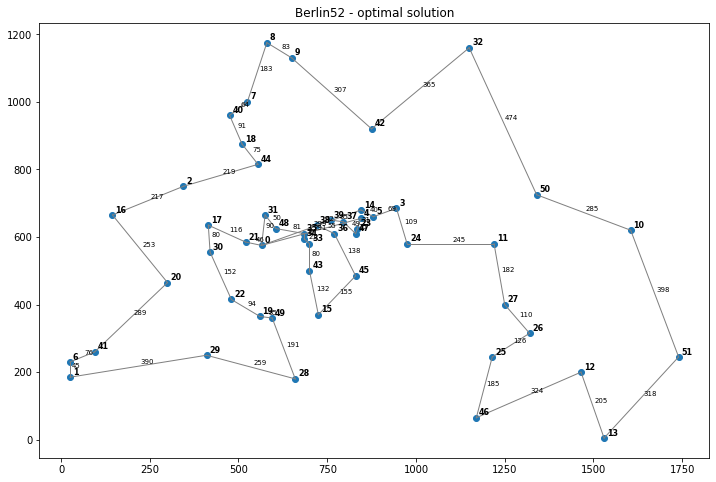

In [92]:
# visualize solution 
plot_route(current_population[0])

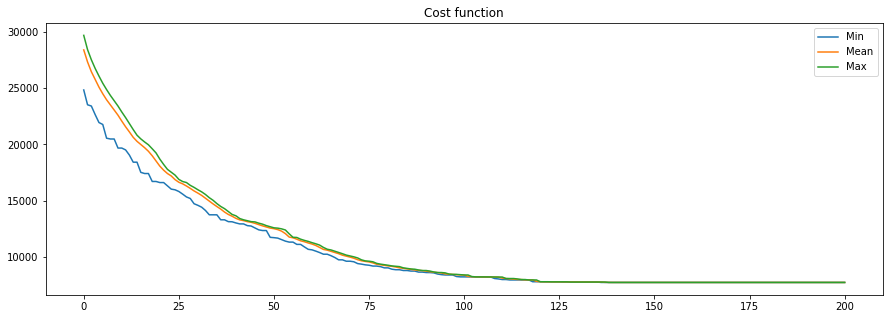

In [93]:
plt.figure(figsize=(15, 5))
plt.plot(cost_values)
plt.title('Cost function')
plt.legend(['Min','Mean', 'Max'], loc='upper right')
plt.show()

## 2. PMX + Random swap of two elements

In [38]:
cost_values, current_population = SGA(mutation_probability=0.5, mutation=random_swap)

iter: 0,     || time: 0.08,     || min: 24637.17,     || mean: 28359.64,     || max: 29720.20,     || std: 1083.05
iter: 10,     || time: 0.61,     || min: 20002.68,     || mean: 22414.14,     || max: 23120.91,     || std: 614.45
iter: 20,     || time: 1.13,     || min: 16010.64,     || mean: 18190.57,     || max: 18857.83,     || std: 522.29
iter: 30,     || time: 1.65,     || min: 13892.91,     || mean: 15355.57,     || max: 15872.62,     || std: 431.35
iter: 40,     || time: 2.16,     || min: 11890.04,     || mean: 13159.81,     || max: 13581.89,     || std: 337.10
iter: 50,     || time: 2.68,     || min: 10990.32,     || mean: 11492.42,     || max: 11649.46,     || std: 119.39
iter: 60,     || time: 3.18,     || min: 10429.05,     || mean: 10620.03,     || max: 10714.40,     || std: 58.23
iter: 70,     || time: 3.70,     || min: 10176.21,     || mean: 10310.28,     || max: 10359.86,     || std: 31.37
iter: 80,     || time: 4.21,     || min: 9959.33,     || mean: 10074.55,     || ma

<Figure size 864x576 with 0 Axes>

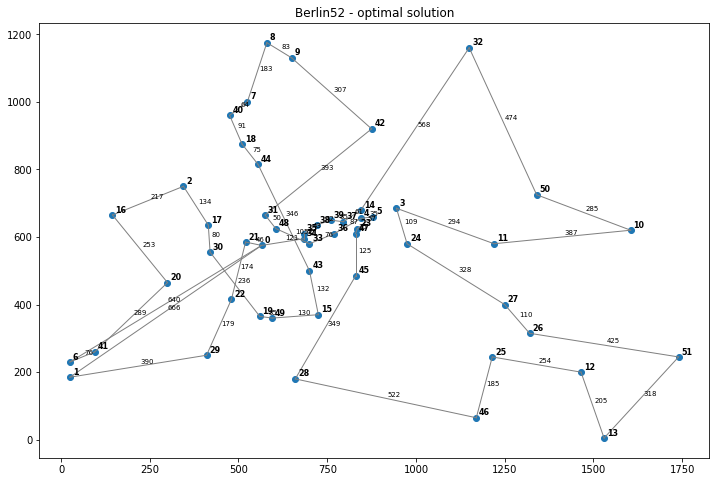

In [39]:
# visualize solution 
plot_route(current_population[0])

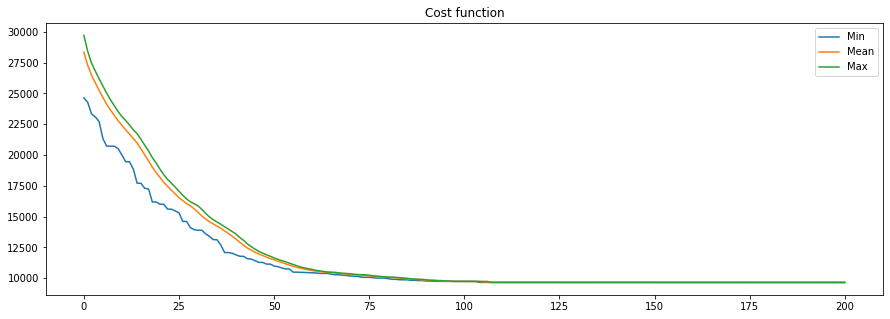

In [40]:
plt.figure(figsize=(15, 5))
plt.plot(cost_values)
plt.title('Cost function')
plt.legend(['Min','Mean', 'Max'], loc='upper right')
plt.show()

## 3. bayg29, bays29, kroA100, kroA150, kroA200

In [85]:
tsp_names = ['bayg29', 'bays29', 'kroA100', 'kroA150', 'kroA200']
tsp_instances = [data.bayg29(), data.bays29(), data.kroA100(), data.kroA150(), data.kroA200()]
iters = [125, 125, 600, 1000, 1000]

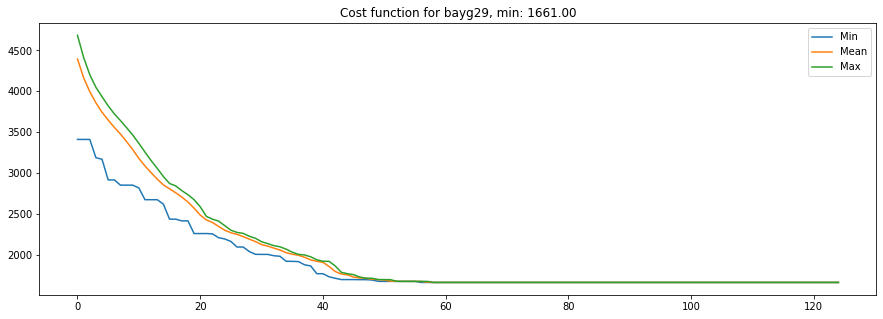

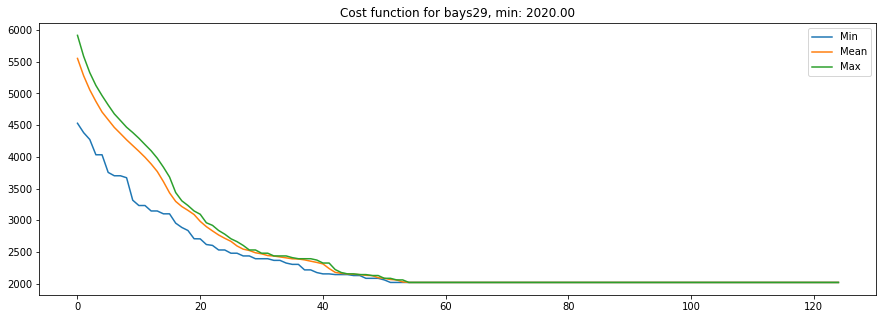

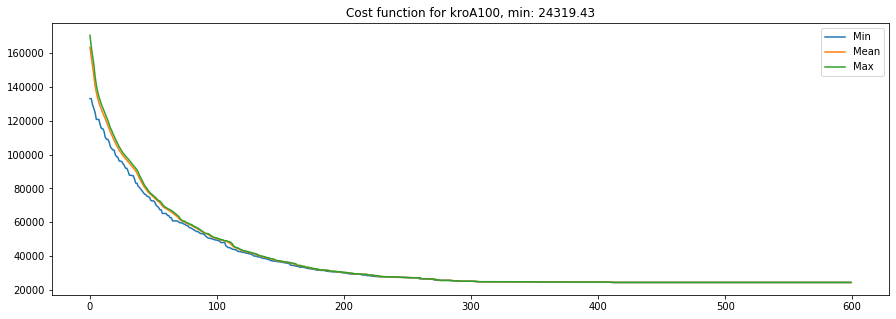

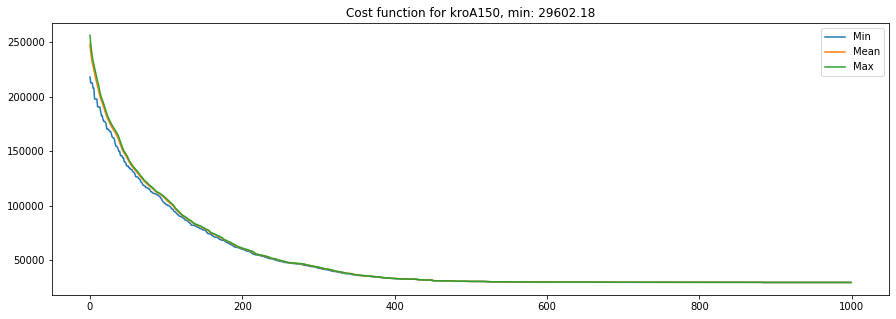

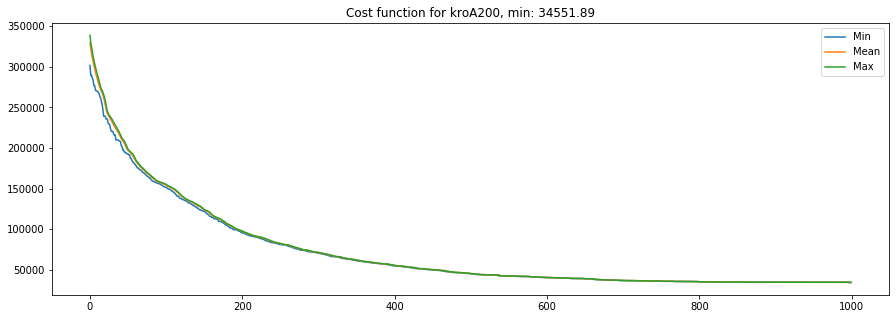

Wall time: 4min 57s


In [86]:
%%time 

for i, (distance_matrix, n) in enumerate(tsp_instances):
    cost_values, current_population = SGA(number_of_iterations=iters[i], 
                                          distance_matrix=distance_matrix, 
                                          chromosome_length=n, 
                                          debug=False)
    plt.figure(figsize=(15, 5))
    plt.plot(cost_values)
    plt.title(f'Cost function for {tsp_names[i]}, min: {np.array(cost_values)[:, 1].min():.2f}')
    plt.legend(['Min','Mean', 'Max'], loc='upper right')
    plt.show()

# Checking another mutation and crossover operators
Evolutionary computation framework deap - [https://deap.readthedocs.io/en/master/api/index.html]

Crossovers:
* cxOnePoint(ind1, ind2)
* cxTwoPoint(ind1, ind2)
* cxUniform(ind1, ind2, indpb) 
    - indpb – Independent probability for each attribute to be exchanged.
* (PMX) cxPartialyMatched(ind1, ind2) 
* (UPMX) cxUniformPartialyMatched(ind1, ind2, indpb)  
* (OX) cxOrdered(ind1, ind2) 
* cxBlend(ind1, ind2, alpha)
    - alpha – Extent of the interval in which the new values can be drawn for each attribute on both side of the parents’ attributes.
* cxESBlend(ind1, ind2, alpha)
* cxESTwoPoint(ind1, ind2)
* cxSimulatedBinary(ind1, ind2, eta)
    - eta – Crowding degree of the crossover. A high eta will produce children resembling to their parents, while a small eta will produce solutions much more different.
* cxMessyOnePoint(ind1, ind2)


Mutations:
* mutGaussian(individual, mu, sigma, indpb)
    - This function applies a gaussian mutation of mean mu and standard deviation sigma on the input individual
* mutShuffleIndexes(individual, indpb)
    - Shuffle the attributes of the input individual and return the mutant.
* mutFlipBit(individual, indpb)
    - Flip the value of the attributes of the input individual and return the mutant
* mutUniformInt(individual, low, up, indpb)
    - Mutate an individual by replacing attributes, with probability indpb
* mutPolynomialBounded(individual, eta, low, up, indpb)
    - Polynomial mutation as implemented in original NSGA-II algorithm in C by Deb.
* mutESLogNormal(individual, c, indpb)
    - Mutate an evolution strategy according to its strategy attribute as described in [Beyer2002].

<img src="images/CX.jpg" />
<img src="images/1PX_OX.png" />
<img src="images/LOX_PBX.png" />
<img src="images/PPX_2PX.png" />

<img src="images/mutations.png" />

In [ ]:
def CX(ind1, ind2):
    n = len(ind1)
    start = np.random.randint(n)
    
    lookup1 = [0] * n
    lookup2 = [0] * n
    for i in range(n):
        lookup1[ind1[i]] = i
        lookup2[ind2[i]] = i
        
    start = 3
    cycle = []
    act = start

    i = 0
    while True:
        cycle.append(act)
        act = ind2[act]
        act = lookup1[act]
       
        if act in cycle:
            break
    
    chld1 = [-1] * n
    chld2 = [-1] * n
    
    for c in cycle:
        chld1[lookup1[c]] = c
        chld2[lookup2[c]] = c
    
    
    used1 = set(chld1)
    used2 = set(chld2)
    
    candidates1 = [x for x in ind2 if x not in used1][::-1]
    candidates2 = [x for x in ind1 if x not in used2][::-1]
    
    for i in range(n):
        if chld1[i] == -1:
            chld1[i] = candidates1.pop()
            
        if chld2[i] == -1:
            chld2[i] = candidates2.pop()
            
    return chld1, chld2

In [79]:
def OX(ind1, ind2):
    n = len(ind1)
    a, b = np.random.randint(0, n, 2)
    if a > b:
        a, b = b, a
        
    chld1 = [-1] * n
    chld2 = [-1] * n
    
    chld1[a: b + 1] = ind1[a: b + 1]
    chld2[a: b + 1] = ind2[a: b + 1]
    
    used1 = set(chld1)
    used2 = set(chld2)
    
    aval1 = [x for x in ind1 if x not in used2][::-1]
    aval2 = [x for x in ind2 if x not in used1][::-1]
    
    for i in range(b + 1, n):
        chld1[i] = aval2.pop()
        chld2[i] = aval1.pop()
        
    for i in range(a):
        chld1[i] = aval2.pop()
        chld2[i] = aval1.pop()
        
    return chld1, chld2

In [14]:
def LOX(ind1, ind2):
    n = len(ind1)
    a, b = np.random.randint(0, n, 2)
    if a > b:
        a, b = b, a
        
    chld1 = [-1] * n
    chld2 = [-1] * n
    
    chld1[a: b + 1] = ind1[a: b + 1]
    chld2[a: b + 1] = ind2[a: b + 1]
    
    used1 = set(chld1)
    used2 = set(chld2)
    
    aval1 = [x for x in ind1 if x not in used2][::-1]
    aval2 = [x for x in ind2 if x not in used1][::-1]
    
    for i in range(a):
        chld1[i] = aval2.pop()
        chld2[i] = aval1.pop()
        
    for i in range(b + 1, n):
        chld1[i] = aval2.pop()
        chld2[i] = aval1.pop()
        
    return chld1, chld2

In [73]:
def PBX(ind1, ind2):
    n = len(ind1)
    r1 = np.random.rand(n)
    r2 = np.random.rand(n)
    
    chld1 = [-1] * n
    chld2 = [-1] * n
    
    for i in range(n):
        if (r1 < 0.5)[i]:
            chld1[i] = ind1[i]
        if (r2 < 0.5)[i]:
            chld2[i] = ind2[i]
            
    
    used1 = set(ind1[r1 < 0.5])
    used2 = set(ind2[r2 < 0.5])
    
    un_used1 = [x for x in ind2 if x not in used1][::-1]
    un_used2 = [x for x in ind1 if x not in used2][::-1]
    
    for i in range(n):
        if chld1[i] == -1:
            chld1[i] = un_used1.pop()
        
        if chld2[i] == -1:
            chld2[i] = un_used2.pop()
    
#     assert(len(set(chld1)) == len(set(chld2)) == n)
    return chld1, chld2

In [16]:
def shift_mutation(p, k):
    n = len(p)
    ans1 = p[:n - k]
    ans2 = p[n - k:]
    
    return np.append(ans2, ans1)

In [85]:
crossovers = [CX,
              OX,
              LOX,
              PMX, 
              PBX,
             ]

mutations = [reverse_sequence_mutation, 
             random_swap, # REM random exchange mutation
             lambda x: shift_mutation(x, k=3) # cyclic shift by k
             ]

cross_names = ['CX', 'OX', 'LOX', 'PMX', 'PBX']
mut_names = ['RS', 'REM', 'CS']

In [86]:
A, n = data.berlin52()

Iter: 1 / 15, time: 0.00
crossover: CX, mutation: RS


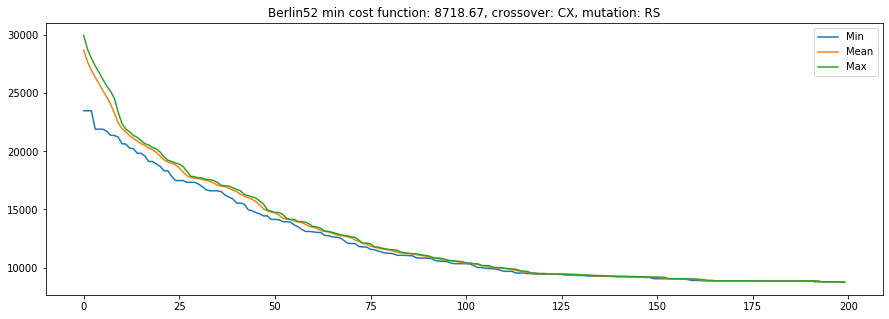

Iter: 2 / 15, time: 0.00
crossover: CX, mutation: REM


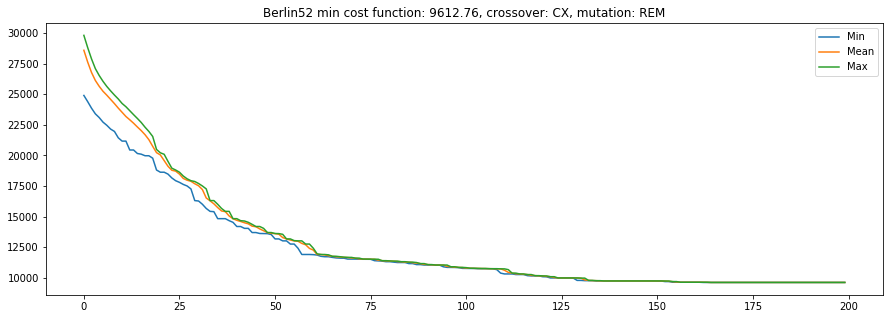

Iter: 3 / 15, time: 0.00
crossover: CX, mutation: CS


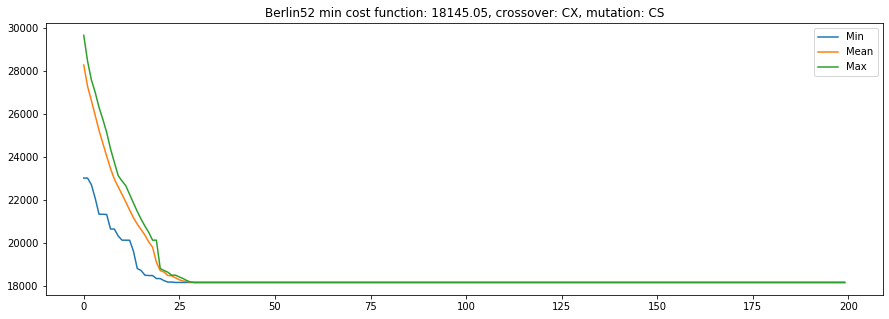

Iter: 4 / 15, time: 0.00
crossover: OX, mutation: RS


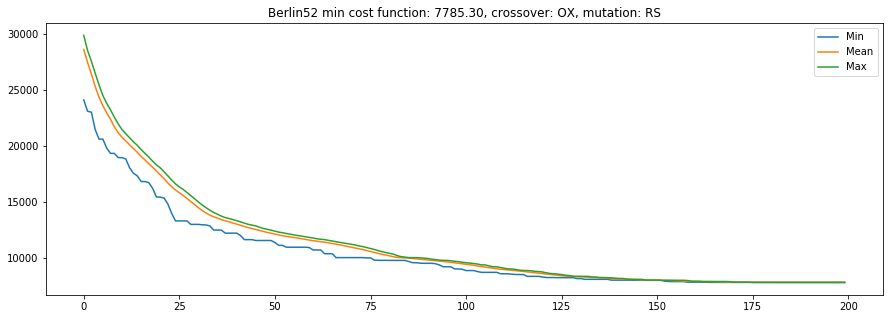

Iter: 5 / 15, time: 0.00
crossover: OX, mutation: REM


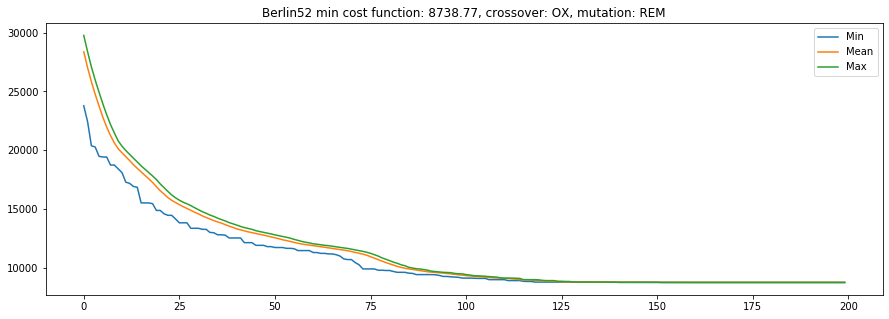

Iter: 6 / 15, time: 0.00
crossover: OX, mutation: CS


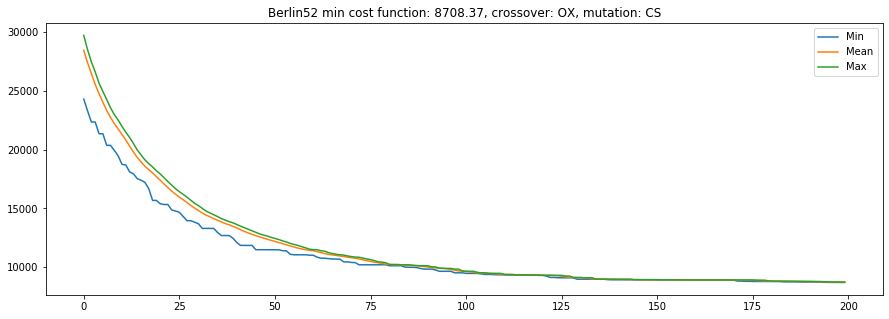

Iter: 7 / 15, time: 0.00
crossover: LOX, mutation: RS


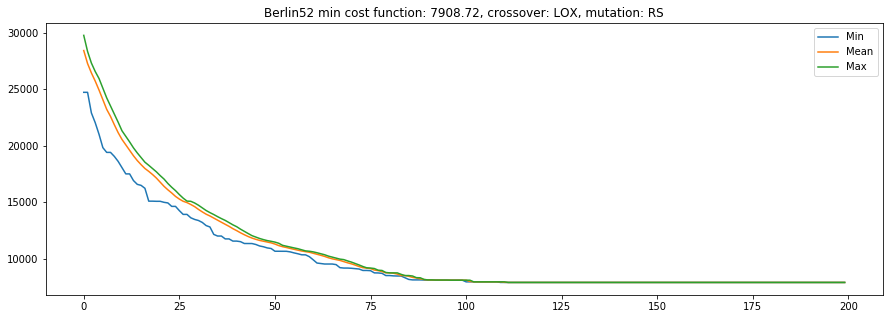

Iter: 8 / 15, time: 0.00
crossover: LOX, mutation: REM


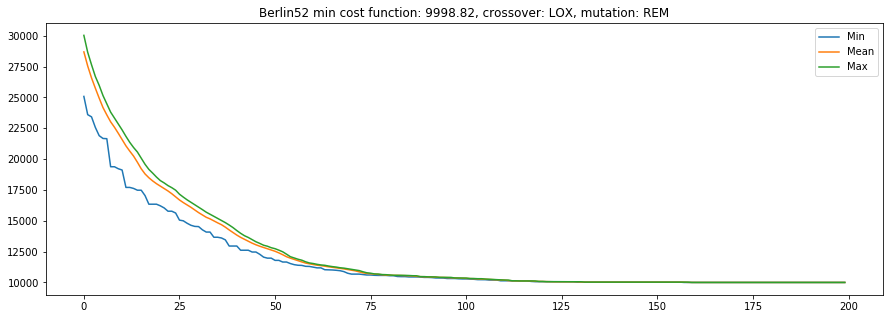

Iter: 9 / 15, time: 0.00
crossover: LOX, mutation: CS


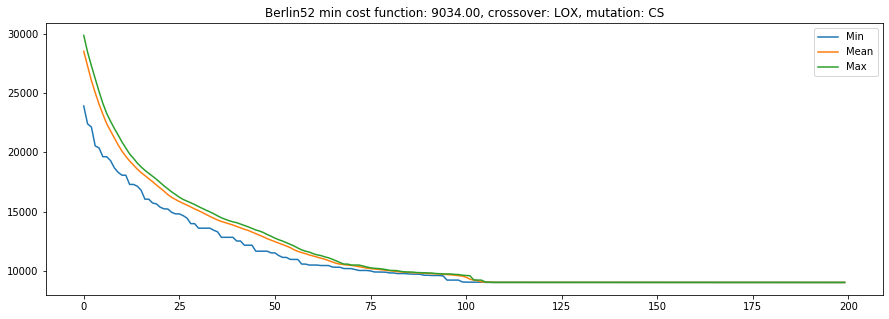

Iter: 10 / 15, time: 0.00
crossover: PMX, mutation: RS


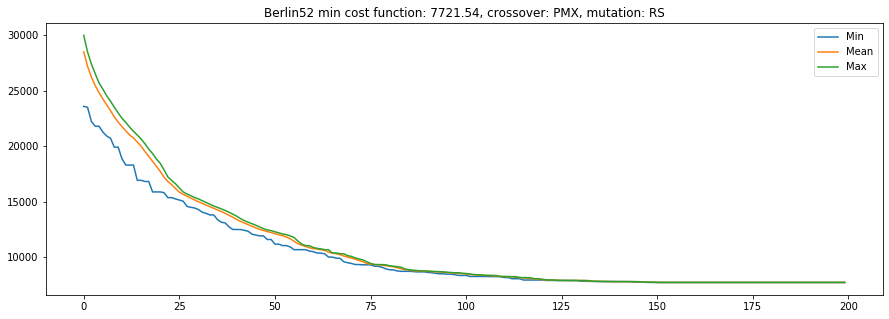

Iter: 11 / 15, time: 0.00
crossover: PMX, mutation: REM


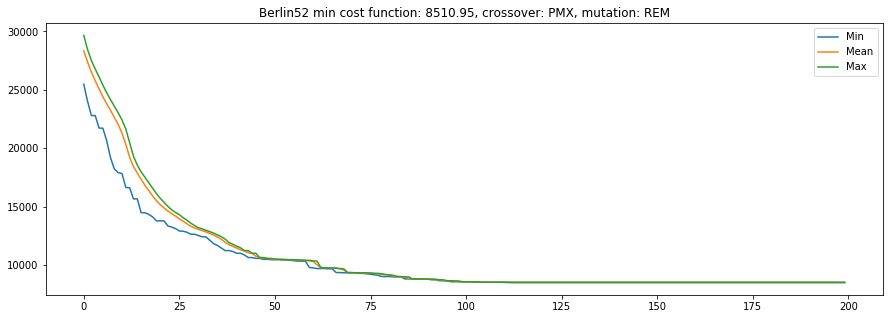

Iter: 12 / 15, time: 0.00
crossover: PMX, mutation: CS


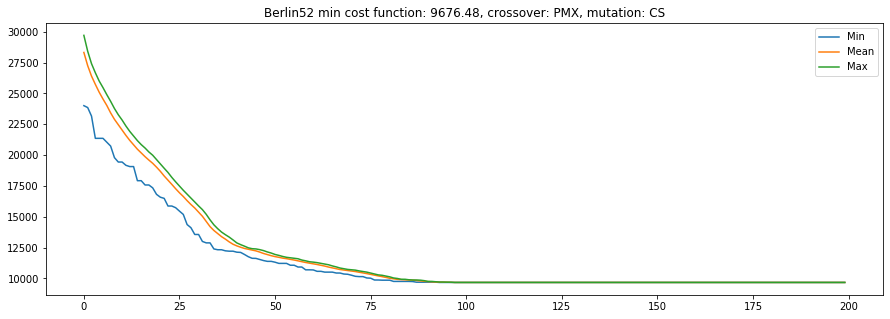

Iter: 13 / 15, time: 0.00
crossover: PBX, mutation: RS


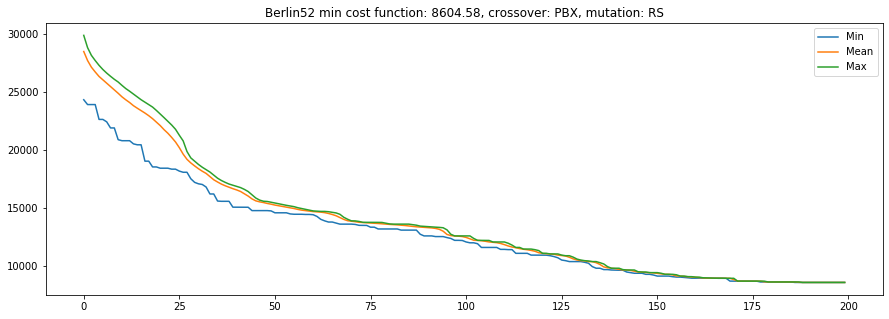

Iter: 14 / 15, time: 0.00
crossover: PBX, mutation: REM


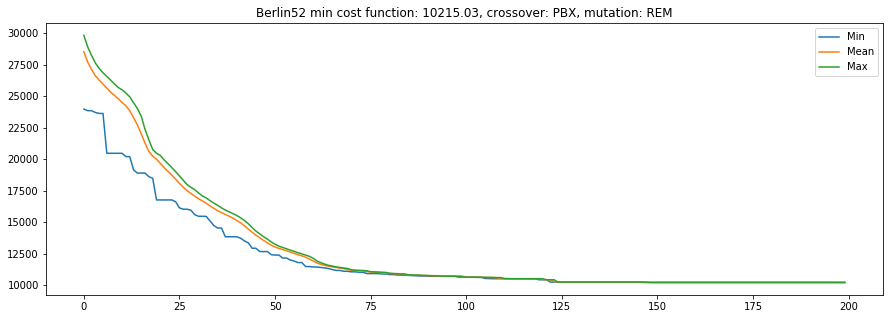

Iter: 15 / 15, time: 0.00
crossover: PBX, mutation: CS


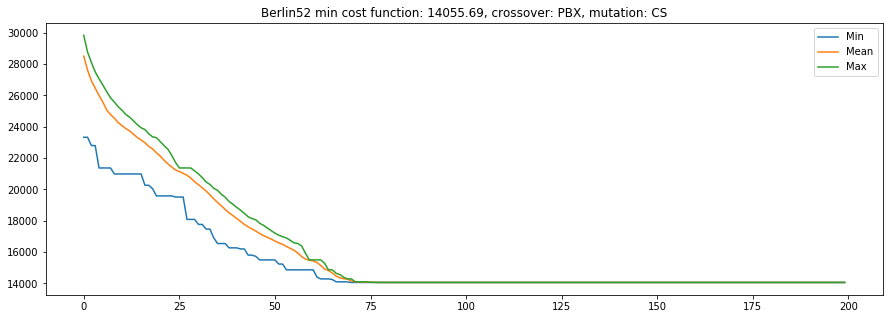

In [95]:
best_score = 1e10
best_chromosome = None
best_pair = None
time0 = time.time()
    
for i, c in enumerate(crossovers):
    for j, m in enumerate(mutations):
        print(f'Iter: {i * len(mutations) + j + 1} / {len(mutations) * len(crossovers)}, time: {time.time() - time.time():.2f}')
        print(f'crossover: {cross_names[i]}, mutation: {mut_names[j]}')
        
        cost_values, current_population = SGA(number_of_iterations=200, 
                                              distance_matrix=A, 
                                              chromosome_length=n, 
                                              crossover=c,
                                              mutation=m,
                                              debug=False)
        
        if cost_values[-1][0] < best_score:
            best_score = cost_values[-1][0]
            best_chromosome = current_population[0]
            best_pair = f'crossover: {cross_names[i]}, mutation: {mut_names[j]}'
        
        plt.figure(figsize=(15, 5))
        plt.plot(cost_values)
        plt.title(f'Berlin52 min cost function: {cost_values[-1][0]:.2f}, crossover: {cross_names[i]}, mutation: {mut_names[j]}')
        plt.legend(['Min','Mean', 'Max'], loc='upper right')
        plt.show()

In [96]:
print(f'Best score: {best_score}, using: {best_pair}')

Best score: 7721.540862065731, using: crossover: PMX, mutation: RS


<Figure size 864x576 with 0 Axes>

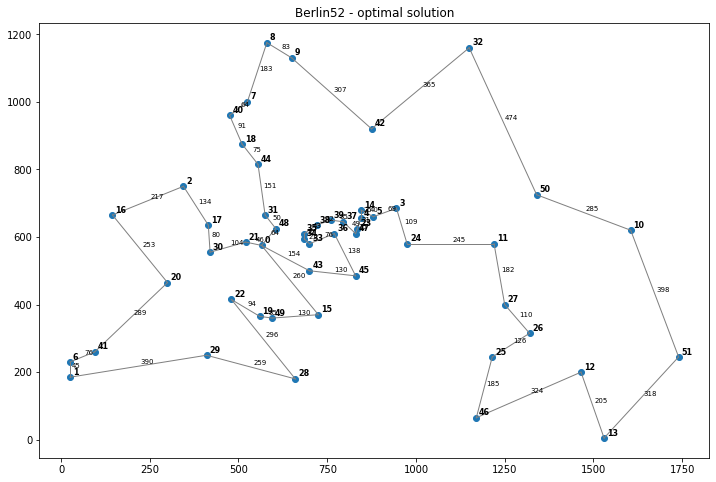

In [97]:
# visualize best solution 
plot_route(best_chromosome)

## Local search mutation

In [121]:
def get_swapped(x):
    n = len(x)
    ans = []
    for i in range(n):
        for j in range(i + 1, n):
            tmp = x.copy()
            tmp[i], tmp[j] = tmp[j], tmp[i]
            ans.append(tmp)
    return np.array(ans)


def local_mutation(p, k, distance_matrix):
    best = p.copy()
    for _ in range(k):
        candidates = get_swapped(p)
        objective_values = tsp_objective_function(candidates, distance_matrix)
        best = candidates[objective_values.argmin()]
    return best

In [129]:
cost_values, current_population = SGA(
    number_of_iterations=150, 
    distance_matrix=A, 
    chromosome_length=n, 
    crossover=PMX,
    mutation=lambda x: local_mutation(reverse_sequence_mutation(x), 1, A),
    debug=True
)

iter: 0,     || time: 0.36,     || min: 23973.10,     || mean: 28396.85,     || max: 29741.91,     || std: 993.85
iter: 10,     || time: 3.10,     || min: 19256.18,     || mean: 22171.06,     || max: 22947.81,     || std: 601.48
iter: 20,     || time: 5.86,     || min: 17353.41,     || mean: 19123.11,     || max: 19560.01,     || std: 363.76
iter: 30,     || time: 8.57,     || min: 14426.04,     || mean: 15970.43,     || max: 16427.05,     || std: 324.25
iter: 40,     || time: 11.37,     || min: 13441.06,     || mean: 14042.64,     || max: 14205.78,     || std: 137.77
iter: 50,     || time: 13.95,     || min: 11593.88,     || mean: 12065.56,     || max: 12201.37,     || std: 112.47
iter: 60,     || time: 16.66,     || min: 10814.68,     || mean: 11032.80,     || max: 11081.85,     || std: 27.60
iter: 70,     || time: 19.54,     || min: 10243.98,     || mean: 10472.35,     || max: 10499.59,     || std: 44.48
iter: 80,     || time: 22.35,     || min: 9821.36,     || mean: 9957.77,     ||

In [126]:
cost_values, current_population = SGA(
    number_of_iterations=150, 
    distance_matrix=A, 
    chromosome_length=n, 
    crossover=PMX,
    mutation=lambda x: local_mutation(reverse_sequence_mutation(x), 2, A),
    debug=True
)

iter: 0,     || time: 0.59,     || min: 24395.92,     || mean: 28305.34,     || max: 29599.04,     || std: 969.75
iter: 10,     || time: 6.45,     || min: 18202.79,     || mean: 22382.70,     || max: 23184.94,     || std: 724.64
iter: 20,     || time: 12.21,     || min: 15621.61,     || mean: 17884.14,     || max: 18438.47,     || std: 501.39
iter: 30,     || time: 18.33,     || min: 13316.75,     || mean: 14936.51,     || max: 15451.30,     || std: 406.12
iter: 40,     || time: 24.14,     || min: 11780.90,     || mean: 12515.04,     || max: 12750.38,     || std: 158.99
iter: 50,     || time: 30.09,     || min: 10949.79,     || mean: 11299.58,     || max: 11405.18,     || std: 87.99
iter: 60,     || time: 36.53,     || min: 10186.29,     || mean: 10531.08,     || max: 10578.00,     || std: 43.36
iter: 70,     || time: 42.68,     || min: 9610.61,     || mean: 9835.88,     || max: 9893.80,     || std: 67.18
iter: 80,     || time: 48.61,     || min: 9177.19,     || mean: 9384.33,     || m

In [127]:
cost_values, current_population = SGA(
    number_of_iterations=150, 
    distance_matrix=A, 
    chromosome_length=n, 
    crossover=PMX,
    mutation=lambda x: local_mutation(reverse_sequence_mutation(x), 3, A),
    debug=True
)

iter: 0,     || time: 0.92,     || min: 24569.25,     || mean: 28352.80,     || max: 29767.80,     || std: 1013.21
iter: 10,     || time: 9.27,     || min: 16655.28,     || mean: 20436.06,     || max: 21233.62,     || std: 596.51
iter: 20,     || time: 17.68,     || min: 15410.33,     || mean: 16399.96,     || max: 16677.54,     || std: 272.78
iter: 30,     || time: 26.25,     || min: 13438.68,     || mean: 14217.61,     || max: 14612.32,     || std: 249.95
iter: 40,     || time: 34.50,     || min: 12183.93,     || mean: 12862.82,     || max: 12987.27,     || std: 198.56
iter: 50,     || time: 42.94,     || min: 11123.72,     || mean: 11525.89,     || max: 11663.99,     || std: 97.50
iter: 60,     || time: 51.01,     || min: 10347.02,     || mean: 10617.25,     || max: 10675.12,     || std: 60.76
iter: 70,     || time: 58.81,     || min: 9845.71,     || mean: 9957.54,     || max: 9959.33,     || std: 12.93
iter: 80,     || time: 67.16,     || min: 9110.10,     || mean: 9119.75,     || 

In [128]:
cost_values, current_population = SGA(
    number_of_iterations=150, 
    distance_matrix=A, 
    chromosome_length=n, 
    crossover=PMX,
    mutation=lambda x: local_mutation(reverse_sequence_mutation(x), 4, A),
    debug=True
)

iter: 0,     || time: 1.17,     || min: 24169.18,     || mean: 28308.62,     || max: 29636.69,     || std: 977.08
iter: 10,     || time: 12.02,     || min: 18395.60,     || mean: 21795.64,     || max: 22670.95,     || std: 722.60
iter: 20,     || time: 22.41,     || min: 15816.75,     || mean: 17963.39,     || max: 18524.71,     || std: 487.96
iter: 30,     || time: 33.26,     || min: 14278.14,     || mean: 15370.94,     || max: 15691.40,     || std: 313.55
iter: 40,     || time: 43.29,     || min: 13049.10,     || mean: 13418.35,     || max: 13564.63,     || std: 145.41
iter: 50,     || time: 53.48,     || min: 11771.15,     || mean: 12263.64,     || max: 12511.26,     || std: 157.88
iter: 60,     || time: 63.20,     || min: 10826.41,     || mean: 11359.46,     || max: 11476.79,     || std: 171.16
iter: 70,     || time: 72.87,     || min: 10826.41,     || mean: 10826.41,     || max: 10826.41,     || std: 0.00
iter: 80,     || time: 82.78,     || min: 10826.41,     || mean: 10826.41,  

## SGA on QAP

In [182]:
def qap_objective_function(p, A, B):
    n = len(p)
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p, p[i]]).sum()
    return s

In [154]:
def get_qap(name):
    QAP_INSTANCE_URL = f'http://anjos.mgi.polymtl.ca/qaplib/data.d/{name}.dat'
    qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        if len(line) < 2:
            continue
        A[i, :] = list(map(int, line.decode()[:-1].split()))
  

    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        if len(line) < 2:
            continue
        B[i, :] = list(map(int, line.decode()[:-1].split()))
  
    return n, A, B

In [184]:
QAPs = []
names = []

for i in range(12, 30):
    try:
        x = get_qap(f'nug{i}')
        QAPs.append(x)
        print(f'Nug {i} appended!')
        names.append(f'Nug{i}')
    except HTTPError:
        print(f'Nug {i} wasn t found :c')
        

tais = ["tai50a", "tai60a", "tai80a"]
for tai in tais:
    try:
        x = get_qap(tai)
        QAPs.append(x)
        print(f'{tai} appended!')
        names.append(f'{tai}')
    except HTTPError:
        print(f'{tai} wasn t found :c')

Nug 12 appended!
Nug 13 wasn t found :c
Nug 14 appended!
Nug 15 appended!
Nug 16 wasn t found :c
Nug 17 appended!
Nug 18 appended!
Nug 19 wasn t found :c
Nug 20 appended!
Nug 21 appended!
Nug 22 appended!
Nug 23 wasn t found :c
Nug 24 appended!
Nug 25 appended!
Nug 26 wasn t found :c
Nug 27 appended!
Nug 28 appended!
Nug 29 wasn t found :c
tai50a appended!
tai60a appended!
tai80a appended!


Nug12 --> best score: 586.0


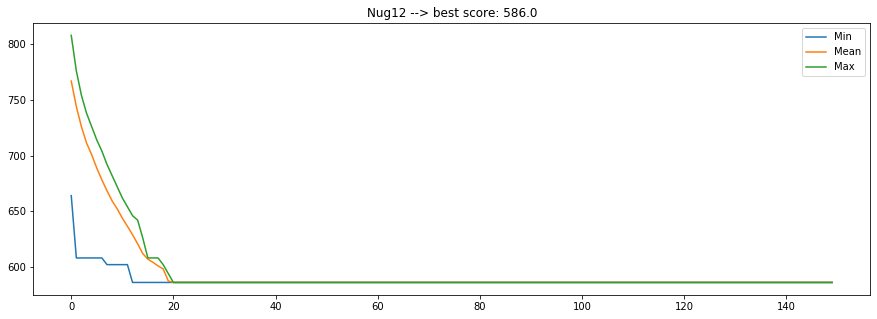

Nug14 --> best score: 1042.0


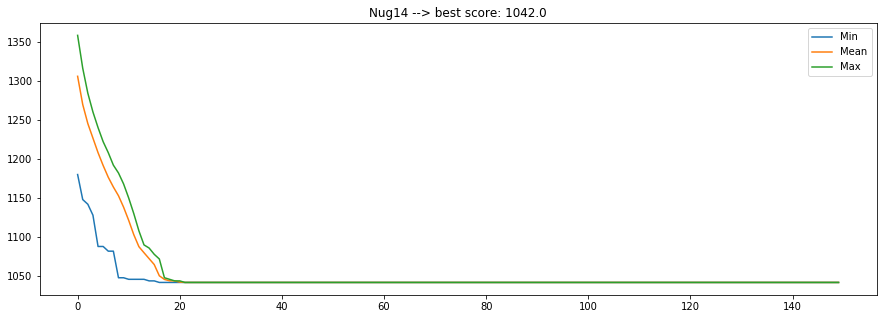

Nug15 --> best score: 1168.0


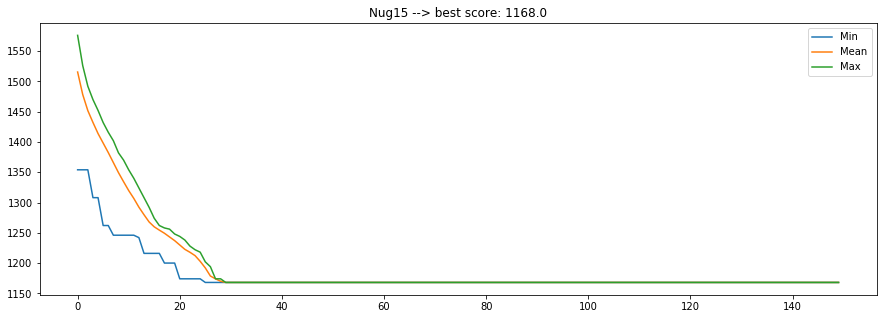

Nug17 --> best score: 1820.0


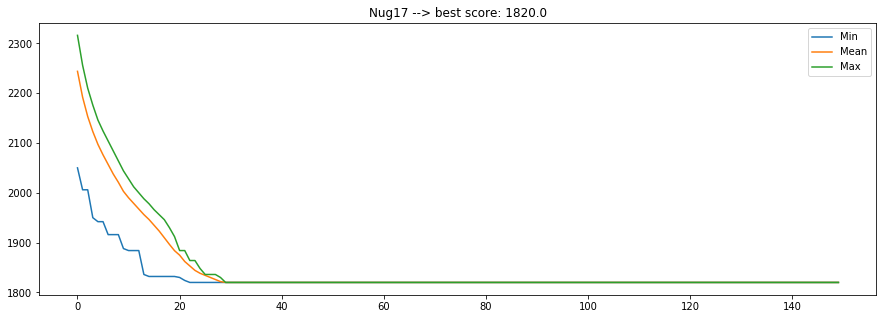

Nug18 --> best score: 1962.0


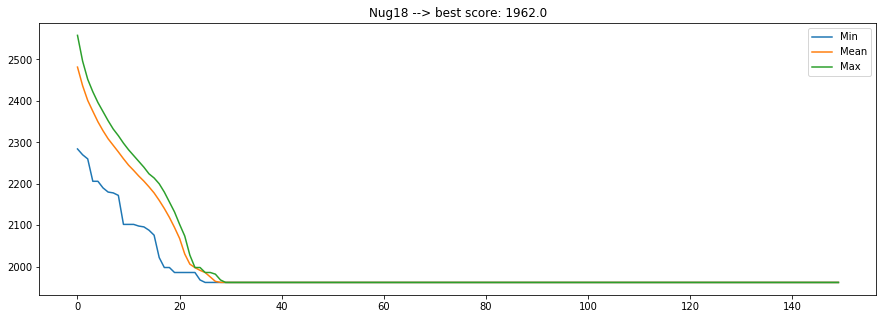

Nug20 --> best score: 2738.0


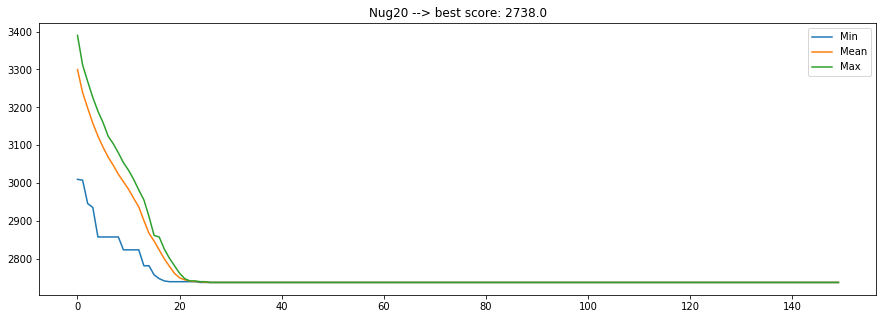

Nug21 --> best score: 2520.0


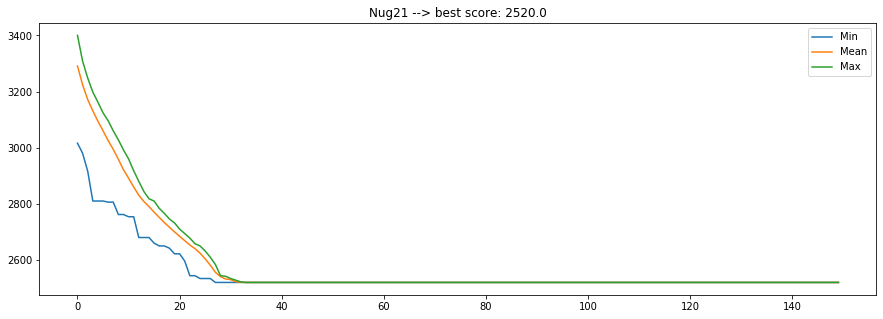

Nug22 --> best score: 3680.0


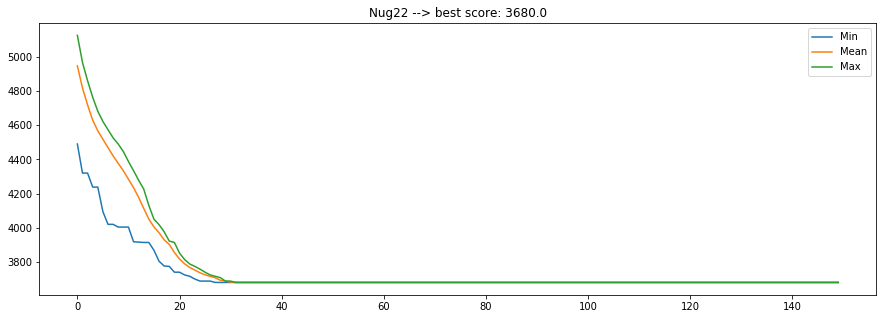

Nug24 --> best score: 3734.0


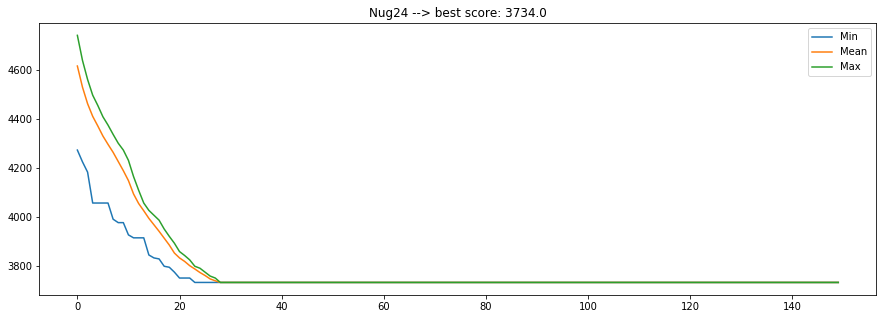

Nug25 --> best score: 3948.0


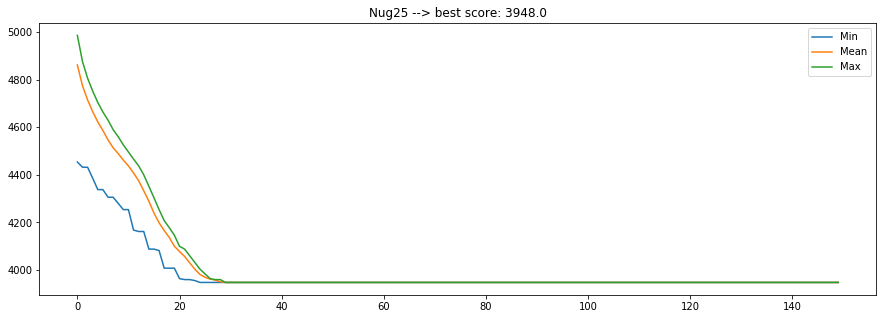

Nug27 --> best score: 5596.0


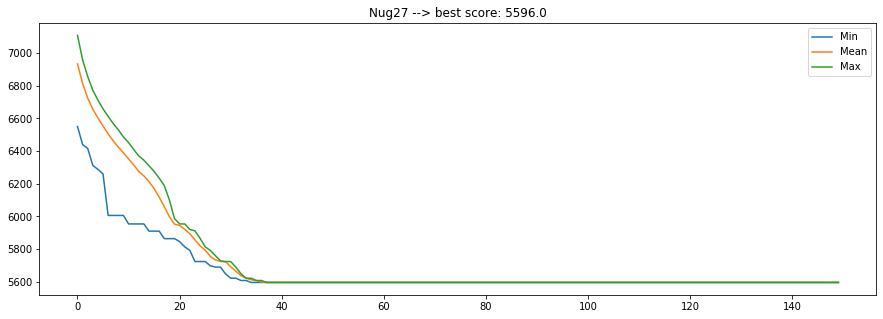

Nug28 --> best score: 5460.0


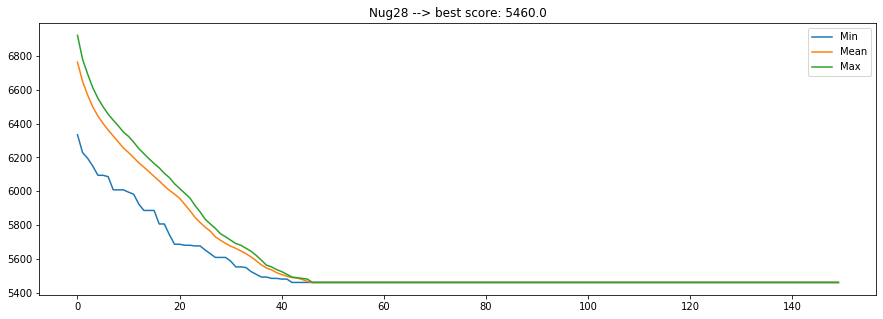

tai50a --> best score: 5374212.0


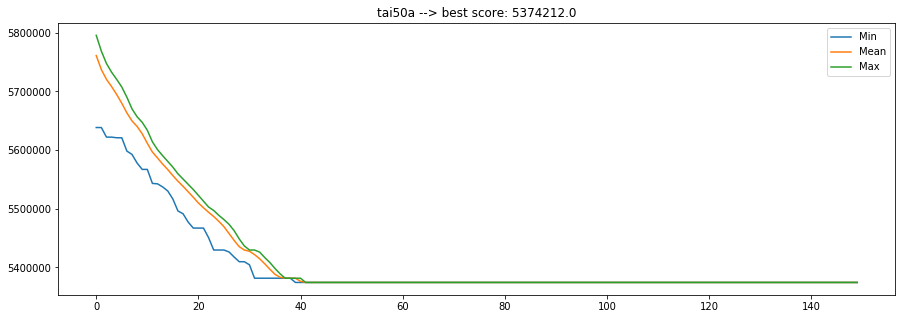

tai60a --> best score: 7633584.0


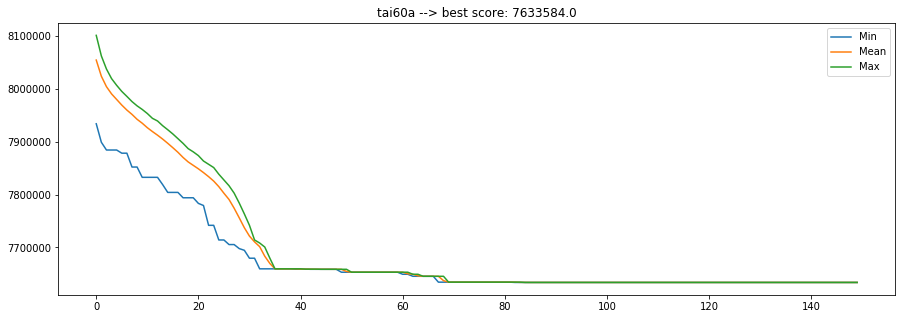

tai80a --> best score: 14324095.0


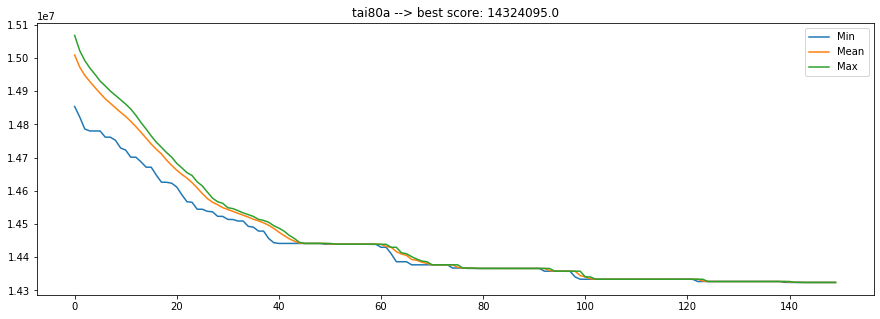

In [187]:
for i, qap in enumerate(QAPs):
    cost_values, current_population = SGA(
        number_of_iterations=150, 
        distance_matrix=qap[2], 
        chromosome_length=qap[0], 
        crossover=PMX,
        mutation=reverse_sequence_mutation,
        objective_function=lambda x, y: qap_objective_function(x, qap[1], y),
        debug=False
    )
    print(f'{names[i]} --> best score: {cost_values[-1][0]}')
    plt.figure(figsize=(15, 5))
    plt.plot(cost_values)
    plt.title(f'{names[i]} --> best score: {cost_values[-1][0]}')
    plt.legend(['Min','Mean', 'Max'], loc='upper right')
    plt.show()

Answers:
- Nug12 12 578 (OPT)
- Nug14 14 1014 (OPT)
- Nug15 15 1150 (OPT)
- Nug16a 16 1610 (OPT) 
- Nug16b 16 1240 (OPT)
- Nug17 17 1732 (OPT) 
- Nug18 18 1930 (OPT) 
- Nug20 20 2570 (OPT) 
- Nug21 21 2438 (OPT)
- Nug22 22 3596 (OPT)
- Nug24 24 3488 (OPT)
- Nug25 25 3744 (OPT)
- Nug27 27 5234 (OPT)
- Nug28 28 5166 (OPT) 
- Nug30 30 6124 (OPT) 

*  Tai50a    50      4938796 (ITS)       4390920 (L&P)             
*  Tai60a    60      7205962 (TS-2)      6325978 (BBCPOP) 
*  Tai80a    80     13499184 (ITS)      11657010 (BBCPOP)  